<a href="https://colab.research.google.com/github/asifsohailmd/Pneumonia-Detection-using-CNN/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To get kaggle.json file go to:

https://www.kaggle.com/username/account

In the API section, click Create New API Token. And upload the downloaded .json file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 17.5MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.3MB/s]


In [ ]:
#Unzip the downloaded files
!unzip /content/chest-xray-pneumonia.zip

In [ ]:
/content/chest_xray

Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

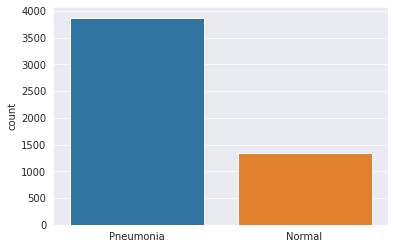

In [ ]:
labels_ = []
for i in train:
    if(i[1] == 0):
        labels_.append("Pneumonia")
    else:
        labels_.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=labels_)

Text(0.5, 1.0, 'NORMAL')

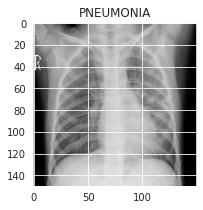

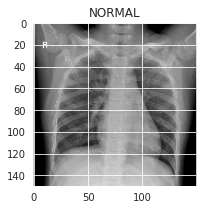

In [ ]:
plt.figure(figsize = (3,3))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (3,3))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 12, 
                    validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 20s 71ms/step - loss: 1.2861 - accuracy: 0.7753 - val_loss: 23.5832 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 11s 68ms/step - loss: 0.2828 - accuracy: 0.8937 - val_loss: 46.8062 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 11s 69ms/step - loss: 0.2314 - accuracy: 0.9143 - val_loss: 20.7610 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 11s 69ms/step - loss: 0.1909 - accuracy: 0.9463 - val_loss: 0.4241 - val_accuracy: 0.8125
Epoch 5/12
163/163 [==============================] - 11s 69ms/step - loss: 0.1623 - accuracy: 0.9492 - val_loss: 1.2976 - val_accuracy: 0.6250
Epoch 6/12
163/163 [==============================] - 11s 68ms/step - loss: 0.1398 - accuracy: 0.9493 - val_loss: 0.7512 - val_accuracy: 0.5625

Epoch 00006: ReduceLROnPlateau reducing learning ra

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 12ms/step - loss: 0.2667 - accuracy: 0.9071
Loss of the model is -  0.2667374014854431
20/20 [==============================] - 0s 11ms/step - loss: 0.2667 - accuracy: 0.9071
Accuracy of the model is -  90.70512652397156 %


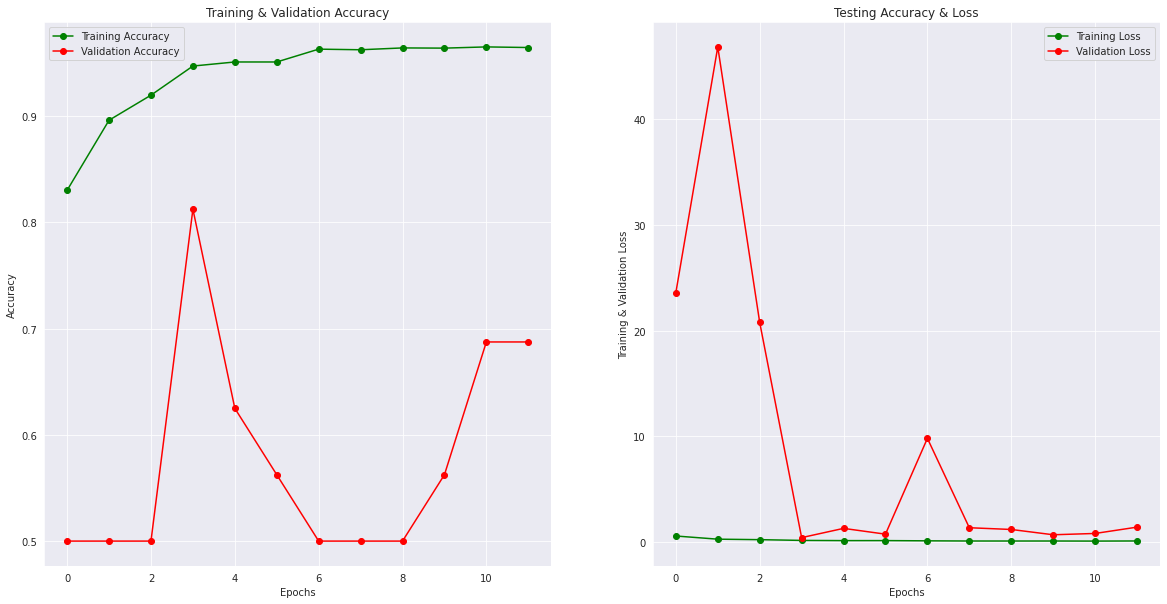

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype(int).flatten()

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.94      0.93       390
   Normal (Class 1)       0.90      0.85      0.87       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[367,  23],
       [ 35, 199]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

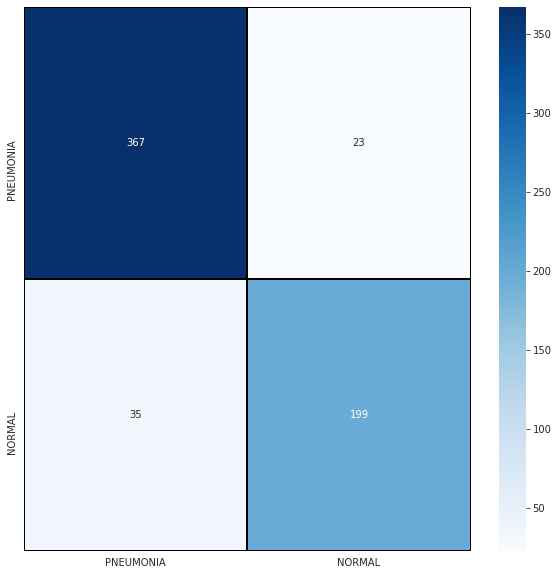

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
model.save('/content/chest_xray')

INFO:tensorflow:Assets written to: /content/chest_xray/assets


In [ ]:
model = keras.models.load_model('/content/chest_xray')

Model Interpretation

In [ ]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sklearn
# import lifelines
# import shap

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [6, 4]

Text(0.5, 1.0, 'PNEUMONIA')

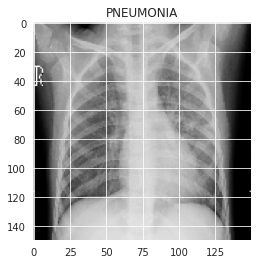

In [ ]:
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [ ]:
max_pooling2d_4

In [ ]:
spatial_maps =  model.get_layer('conv2d_4 ').output
print(spatial_maps)

ValueError: ignored

In [ ]:
get_spatial_maps = K.function([model.input], [spatial_maps])
print(get_spatial_maps)

<function function.<locals>.func at 0x7ff476c8a8c8>


In [ ]:
# get an image
x = train[0][0]
x = np.expand_dims(x, axis=0)
print(f"x is of type {type(x)}")
print(f"x is of shape {x.shape}")

x is of type <class 'numpy.ndarray'>
x is of shape (1, 150, 150)


In [ ]:
# get the spatial maps layer activations (a list of numpy arrays)
spatial_maps_x_l = get_spatial_maps([x])

print(f"spatial_maps_x_l is of type {type(spatial_maps_x_l)}")
print(f"spatial_maps_x_l is has length {len(spatial_maps_x_l)}")

spatial_maps_x_l is of type <class 'list'>
spatial_maps_x_l is has length 1


In [ ]:
# get the 0th item in the list
spatial_maps_x = spatial_maps_x_l[0]
print(f"spatial_maps_x is of type {type(spatial_maps_x)}")
print(f"spatial_maps_x is of shape {spatial_maps_x.shape}")

spatial_maps_x is of type <class 'numpy.ndarray'>
spatial_maps_x is of shape (1, 5, 5, 256)


In [ ]:
# Get rid of the batch dimension
spatial_maps_x = spatial_maps_x[0] # equivalent to spatial_maps_x[0,:]
print(f"spatial_maps_x without the batch dimension has shape {spatial_maps_x.shape}")
print("Output some of the content:")
print(spatial_maps_x[0])

spatial_maps_x without the batch dimension has shape (5, 5, 256)
Output some of the content:
[[-2.0987099e-01 -6.1571658e-01  3.1407501e+02 ... -5.0988019e-01
   1.7699718e+03  5.9829785e+02]
 [-2.0987099e-01 -6.1571658e-01  2.9034335e+02 ... -5.0988019e-01
   1.6090129e+03  4.9634732e+02]
 [-2.0987099e-01 -6.1571658e-01  5.6391003e+02 ... -5.0988019e-01
   1.5409159e+03  3.9996191e+02]
 [-2.0987099e-01 -6.1571658e-01  4.2332635e+02 ... -5.0988019e-01
   1.4746689e+03  2.7720685e+02]
 [-2.0987099e-01  4.6159735e+02  2.7391218e+01 ...  5.5788068e+02
   6.5461060e+02 -4.1773722e-01]]


In [ ]:
# get the output of the model
output_with_batch_dim = model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")

Model output includes batch dimension, has shape (None, 1)


In [ ]:
# Get the output without the batch dimension
output_all_categories = output_with_batch_dim[0]
print(f"The output for all 14 categories of disease has shape {output_all_categories.shape}")

The output for all 14 categories of disease has shape (1,)


In [ ]:
# Get the first category's output (Cardiomegaly) at index 0
y_category_0 = output_all_categories[0]
print(f"The Cardiomegaly output is at index 0, and has shape {y_category_0.shape}")

The Cardiomegaly output is at index 0, and has shape ()


In [ ]:
# Get gradient of y_category_0 with respect to spatial_maps

gradient_l = K.gradients(y_category_0, spatial_maps)
print(f"gradient_l is of type {type(gradient_l)} and has length {len(gradient_l)}")

# gradient_l is a list of size 1.  Get the gradient at index 0
gradient = gradient_l[0]
print(gradient)

RuntimeError: ignored